In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Joins

This section introduces *joins* in `pandas`, a very useful operation for
combining two or more dataframes together.

We'll continue looking at the baby names data. We'll use joins to check some
trends mentioned in the New York Times article about baby names
{cite}`williamsLilith2021`. The article talks about how certain categories of
names have become more or less popular over time. For instance, it mentions
that mythological names like Julius and Cassius have become popular, while baby
boomer names like Susan and Debbie have become less popular. How has the
popularity of these categories changed over time?

We've taken the names and categories in the NYT article and put them in a small
dataframe:

In [14]:
nyt = pd.read_csv('nyt_names.csv')
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
...,...,...
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


To see how popular the categories of names are, you need to join the
`nyt` dataframe with the `baby` dataframe since the `baby` table holds
the actual name counts.

In [3]:
baby = pd.read_csv('babynames.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


Imagine going down each row in `baby` and asking, is this name in the `nyt`
table? If so, then add the value in the `category` column to the row. That's
the basic idea behind a join. Let's look at a few simpler examples first.

## Inner Joins

We'll make smaller versions of the `baby` and `nyt` tables so it's easier to
see what happens when we join tables together.

In [54]:
nyt_small = nyt.iloc[[11, 12, 14]].reset_index(drop=True)
nyt_small

,nyt_name,category
0,Karen,boomer
1,Julius,mythology
2,Freya,mythology


In [49]:
names_to_keep = ['Julius', 'Karen', 'Noah']
baby_small = (baby
 .query("Year == 2020 and Name in @names_to_keep")
 .reset_index(drop=True)
)
baby_small

,Name,Sex,Count,Year
0,Noah,M,18252,2020
1,Julius,M,960,2020
2,Karen,M,6,2020
3,Karen,F,325,2020
4,Noah,F,305,2020


To join tables in `pandas`, use the `.merge()` method:

In [50]:
baby_small.merge(nyt_small,
                 left_on='Name',        # column in left table to match
                 right_on='nyt_name')   # column in right table to match

,Name,Sex,Count,Year,nyt_name,category
0,Julius,M,960,2020,Julius,mythology
1,Karen,M,6,2020,Karen,boomer
2,Karen,F,325,2020,Karen,boomer


Notice that the new table has the columns of both `baby_small` and `nyt_small`
tables. The rows with the name Noah are gone. And the remaining rows have their
matching `category` from `nyt_small`.

When we join two tables together, we tell `pandas` the column(s) from each
table that we want to use to join (the `left_on` and `right_on` arguments).
`pandas` matches rows together when the values in the joining columns match, as
shown in {numref}`fig:inner-join`.

```{figure} figures/inner-join.svg
---
name: fig:inner-join
alt: inner-join
---
To join, `pandas` matches rows using the values in the `Name` and `nyt_name`
columns. For inner joins (the default), rows that don't have matching values
are dropped.
```

By default, `pandas` does an *inner join*. If either table has rows that don't
have matches in the other table, `pandas` drops those rows from the result. In
this case, the Noah rows in `baby_small` don't have matches in
`nyt_small`, so they are dropped. Also, the Freya row in `nyt_small`
doesn't have matches in `baby_small`, so it's dropped as well. Only the
rows with a match in both tables stay in the final result.

## Left, Right, and Outer Joins

You will sometimes want to keep rows without a match instead of dropping them
entirely. There are other types of joins---left, right, and outer---that keep
rows even when they don't have a match.

In a *left join*, rows in the left table without a match are kept in the final
result, as shown in {numref}`fig:left-join`.

```{figure} figures/left-join.svg
---
name: fig:left-join
alt: left-join
---
In a left join, rows in the left table that don't have matching values are kept. 
```

To do a left join in `pandas`, use `how='left'` in the call to `.merge()`:

In [55]:
baby_small.merge(nyt_small,
                 left_on='Name',        
                 right_on='nyt_name',
                 how='left')           # left join instead of inner

,Name,Sex,Count,Year,nyt_name,category
0,Noah,M,18252,2020,NaN,NaN
1,Julius,M,960,2020,Julius,mythology
2,Karen,M,6,2020,Karen,boomer
3,Karen,F,325,2020,Karen,boomer
4,Noah,F,305,2020,NaN,NaN


Notice that the Noah rows are kept in the final table. Since those rows didn't
have a match in the `nyt_small` dataframe, the join leaves `NaN` values in the
`nyt_name` and `category` columns. Also, notice that the Freya row in
`nyt_small` is still dropped.

A *right join* works similarly to the left join, except that non-matching rows
in the right table are kept instead of the left table:

In [56]:
baby_small.merge(nyt_small,
                 left_on='Name',        
                 right_on='nyt_name',
                 how='right')

,Name,Sex,Count,Year,nyt_name,category
0,Karen,M,6.0,2020.0,Karen,boomer
1,Karen,F,325.0,2020.0,Karen,boomer
2,Julius,M,960.0,2020.0,Julius,mythology
3,NaN,NaN,NaN,NaN,Freya,mythology


Finally, an *outer join* keeps rows from both tables even when they don't have
a match. 

In [57]:
baby_small.merge(nyt_small,
                 left_on='Name',        
                 right_on='nyt_name',
                 how='outer')

,Name,Sex,Count,Year,nyt_name,category
0,Noah,M,18252.0,2020.0,NaN,NaN
1,Noah,F,305.0,2020.0,NaN,NaN
2,Julius,M,960.0,2020.0,Julius,mythology
3,Karen,M,6.0,2020.0,Karen,boomer
4,Karen,F,325.0,2020.0,Karen,boomer
5,NaN,NaN,NaN,NaN,Freya,mythology


## Example: Popularity of NYT Name Categories

Now, let's return to the full dataframes `baby` and `nyt`.

In [58]:
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


In [59]:
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
...,...,...
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


We want to know how the popularity of name categories in `nyt` have changed
over time. To answer this question:

1. Inner join `baby` with `nyt`.
2. Group the table by `category` and `Year`
3. Aggregate the counts using a sum.

In [64]:
cate_counts = (
    baby.merge(nyt, left_on='Name', right_on='nyt_name') # [1]
    .groupby(['category', 'Year'])                       # [2]
    ['Count']                                            # [3]
    .sum()                                               # [3]
    .reset_index()
)
cate_counts

,category,Year,Count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
...,...,...,...
647,mythology,2018,2944
648,mythology,2019,3320
649,mythology,2020,3489


Now, we can plot the popularity of individual categories:

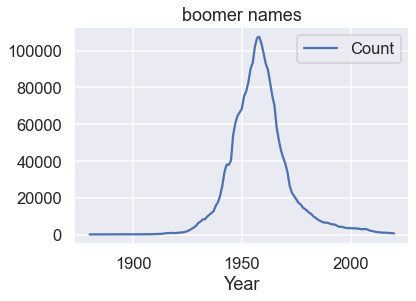

In [69]:
(cate_counts
 .query('category == "boomer"')
 .plot('Year', 'Count')
)
plt.title('boomer names');

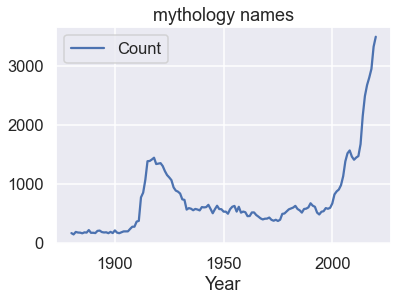

In [70]:
(cate_counts
 .query('category == "mythology"')
 .plot('Year', 'Count')
)
plt.title('mythology names');

As the NYT article claims, "baby boomer" names have become less popular after
2000, while mythological names have become more popular.

With a bit of extra plotting knowledge and the `seaborn` package, you can plot
the popularities of all the categories at once. We won't explain this code
since we cover `seaborn` in more depth in the {ref}`ch:viz` chapter.
Instead, look over the plots below and see whether they support the claims made
in the New York Times article.

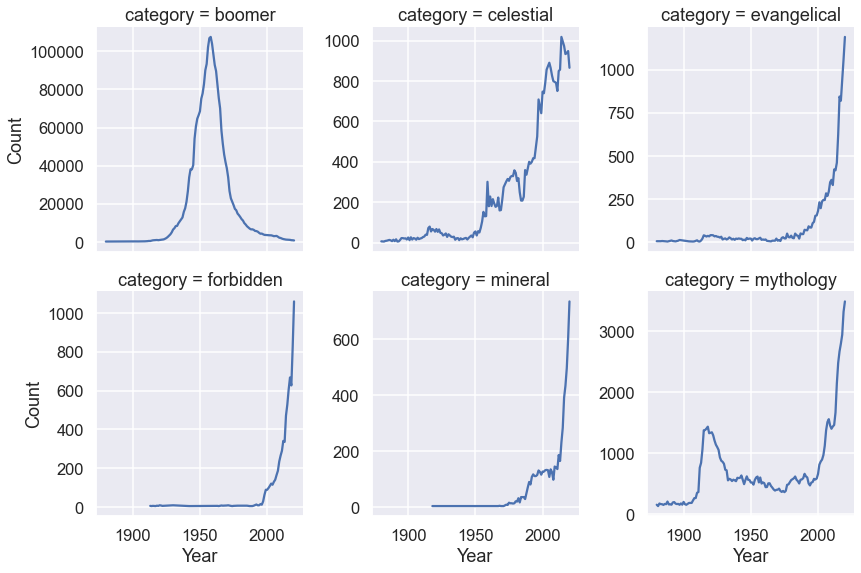

In [78]:
sns.relplot(data=cate_counts, x='Year', y='Count',
            col='category', kind='line', col_wrap=3,
            facet_kws={'sharey': False},
            height=4);

## Exercises

- Come up with a realistic data example where a data scientist would prefer an
  inner join to a left join, and an example where a data scientist would
  prefer a left join to an inner join.

- In this section, the `nyt` table doesn't have any duplicate names. But a name
  could feasibly belong to multiple categories---for instance, `Elizabeth` is
  a name from the Bible and a name for royalty. Let's say the `nyt` table lists
  a name once for each category it belongs to, e.g.:

In [97]:
multi_cat = pd.DataFrame([
    ['Elizabeth', 'bible'],
    ['Elizabeth', 'royal'],
    ['Arjun', 'hindu'],
    ['Arjun', 'mythological'],
], columns=nyt_small.columns)
multi_cat

,nyt_name,category
0,Elizabeth,bible
1,Elizabeth,royal
2,Arjun,hindu
3,Arjun,mythological


What happens when we join `baby` with this table? In general, what happens when
there are *multiple rows* that match in both left and right tables?

- In a *self-join*, we take a table and join it with itself. For example, the
  `friends` table contains pairs of people who are friends with each other.

In [102]:
friends = pd.DataFrame([
    ['Jim', 'Scott'],
    ['Scott', 'Philip'],
    ['Philip', 'Tricia'],
    ['Philip', 'Ailie'],
], columns=['self', 'other'])
friends

,self,other
0,Jim,Scott
1,Scott,Philip
2,Philip,Tricia
3,Philip,Ailie


Why might a data scientist find the following self-join useful?

In [104]:
friends.merge(friends, left_on='other', right_on='self')

,self_x,other_x,self_y,other_y
0,Jim,Scott,Scott,Philip
1,Scott,Philip,Philip,Tricia
2,Scott,Philip,Philip,Ailie
